## Sentiment analysis on the NoReC dataset, using naive bayes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

# Run these if you cannot import the nltk libs.
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

In [2]:
reviews = pd.read_csv('data/data.csv', encoding='utf-8')
reviews['sentiment'] = [(1 if rating > 3 else 0) for rating in reviews.loc[:, 'rating']]

In [3]:
print(len(reviews), 'records')
reviews.head()

43614 records


,category,cons,language,pros,rating,source,source-category,source-tags,split,tags,content,sentiment
0,screen,NaN,nb,NaN,6,p3,tv,[],train,['tv'],rom s topp inn tvdram akkurat andr sist sesong...,1
1,screen,NaN,nb,NaN,6,p3,tv,[],train,['tv'],twin peaks definitiv gold box edition gull twi...,1
2,screen,NaN,nb,NaN,6,p3,tv,[],train,['tv'],the wir sesong the wir gjør avheng god måt nes...,1
3,screen,NaN,nb,NaN,5,p3,tv,[],train,['tv'],mad sesong stil underhold sofistiker tvseri ma...,1
4,screen,NaN,nb,NaN,5,p3,film,[],train,['movie'],mad sesong tvunderholdning høyest kvalit først...,1


In [4]:
def train_test_split(df, content):
    """
    Split into train vs test & dev
    """
    idxTrain = [i for i,s in zip(df.index, df.split) if s == 'train']
    idxTestDev = [i for i,s in zip(df.index, df.split) if s != 'train']    
    return content[idxTrain,:], content[idxTestDev,:], np.array(df.iloc[idxTrain].sentiment), np.array(df.iloc[idxTestDev].sentiment)

#### Split into train & test
Using Multinomial Naive Bayes

In [5]:
reviews.sentiment.value_counts() # 1 = positive, 0 = negative. As we can see, much larger amount of pos. reviews!

1    32910
0    10704
Name: sentiment, dtype: int64

In [6]:
cv = CountVectorizer()
review_content_tf = cv.fit_transform(reviews.content)

In [7]:
review_content_tf.shape

(43614, 368211)

In [8]:
trainX, testX, trainY, testY = train_test_split(reviews, review_content_tf)

In [71]:
mnb = MultinomialNB(class_prior=[0.4,0.6]) # Set prior to help account for the review score bias.
mnb.fit(trainX, trainY)

MultinomialNB(alpha=1.0, class_prior=[0.4, 0.6], fit_prior=True)

In [72]:
y_pred = mnb.predict(testX)

In [73]:
print("Out of", len(testY), 'points, our accuracy were {:.03f}%.'.format(100*(1-(y_pred != testY).sum()/len(testY))))

Out of 8711 points, our accuracy were 81.013%.


In [74]:
m = confusion_matrix(y_true=testY, y_pred=y_pred)
m

array([[ 957, 1004],
       [ 650, 6100]], dtype=int64)

### ROC, AUC Curve

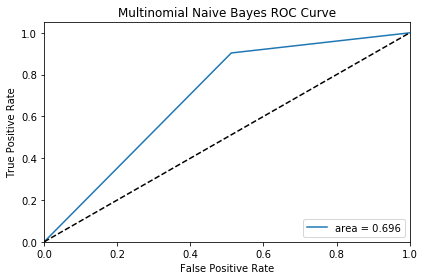

In [75]:
fpr,tpr,_ = roc_curve(testY, y_pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,label='area = %.3f' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multinomial Naive Bayes ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./img/auc_naive_bayes', transparent=False, bbox_inches='tight')
plt.show()

### F1 Score, Precision / Recall

In [76]:
precision = m[1,1] / np.sum(m[:,1])
recall = m[1,1] / np.sum(m[1,:])
f1 = 2 * ((precision * recall) / (precision + recall))
print('F1 Score', f1, 'Recall', recall, 'Precision', precision)

F1 Score 0.8806120975891439 Recall 0.9037037037037037 Precision 0.8586711711711712


### Testing the model

In [77]:
word_stemmer = SnowballStemmer("norwegian", ignore_stopwords=False)
excludedStopWords = set(['ikkje', 'ikke', 'inkje'])
stopWords = set([word for word in set(stopwords.words('norwegian')) if word not in excludedStopWords])
FEATURES = cv.get_feature_names()

In [78]:
def predictReview(text, classifier):
    """
    Quickly classify test reviews using our model.
    Do some quick preprocessing, (copy pasted from preprocessing.ipynb....)
    """
    text = text.strip().lower()
    text = re.sub(r'[^a-zA-ZæøåÆØÅéäöÄÖ -!?]+', '', text) # Remove any symbols
    text = re.sub(r'\s\s+', ' ', text) # Remove consequent whitespace    
    text = [word_stemmer.stem(word) for word in word_tokenize(text) if word not in stopWords]
    
    word_count = {w:0 for w in FEATURES}
    for w in text:
        if w in word_count:
            word_count[w] += 1
    
    text_tf = np.array([[v for _,v in word_count.items()]])
    res = classifier.predict(text_tf)
    return res[0]

In [79]:
test_reviews = [
    'dårlig film! får lyst til å spy!',
    'ikke gale!',
    'den trenger litt finpuss men ellers helt fin',
    'den falt ikke i min smak, håper på at sesong 3 blir bedre',
    'det kan ikke bli værre musikk en dette her',
]

In [80]:
[predictReview(review, mnb) for review in test_reviews] 

[0, 1, 1, 1, 0]